In [5]:
import os
import sys

sys.path.append('../')


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.data import load_mat
from utils.visualization import *

data_path = '../data/'
results_path = '../results/'

### Load Images

In [6]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
SoS = load_mat(os.path.join(data_path, 'SoS.mat'))
SoS_sb = load_mat(os.path.join(data_path, 'SoS_SB.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation.mat'))
rec_das_sb = load_mat(os.path.join(results_path, 'das_simulation_sb.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation.mat'))
rec_apact_sb = load_mat(os.path.join(results_path, 'apact_simulation_sb.mat'))
rec_wiener = load_mat(os.path.join(results_path, 'sb_wiener_simulation.mat'))    
rec_wiener_sb = load_mat(os.path.join(results_path, 'sb_wiener_simulation_sb.mat'))

In [7]:
[IP_img, gt, rec_das, rec_das_sb, rec_apact, rec_apact_sb, rec_wiener, rec_wiener_sb] = [normalize(img) for img in [IP_img, gt, rec_das, rec_das_sb, rec_apact, rec_apact_sb, rec_wiener, rec_wiener_sb]]

### Create Figure

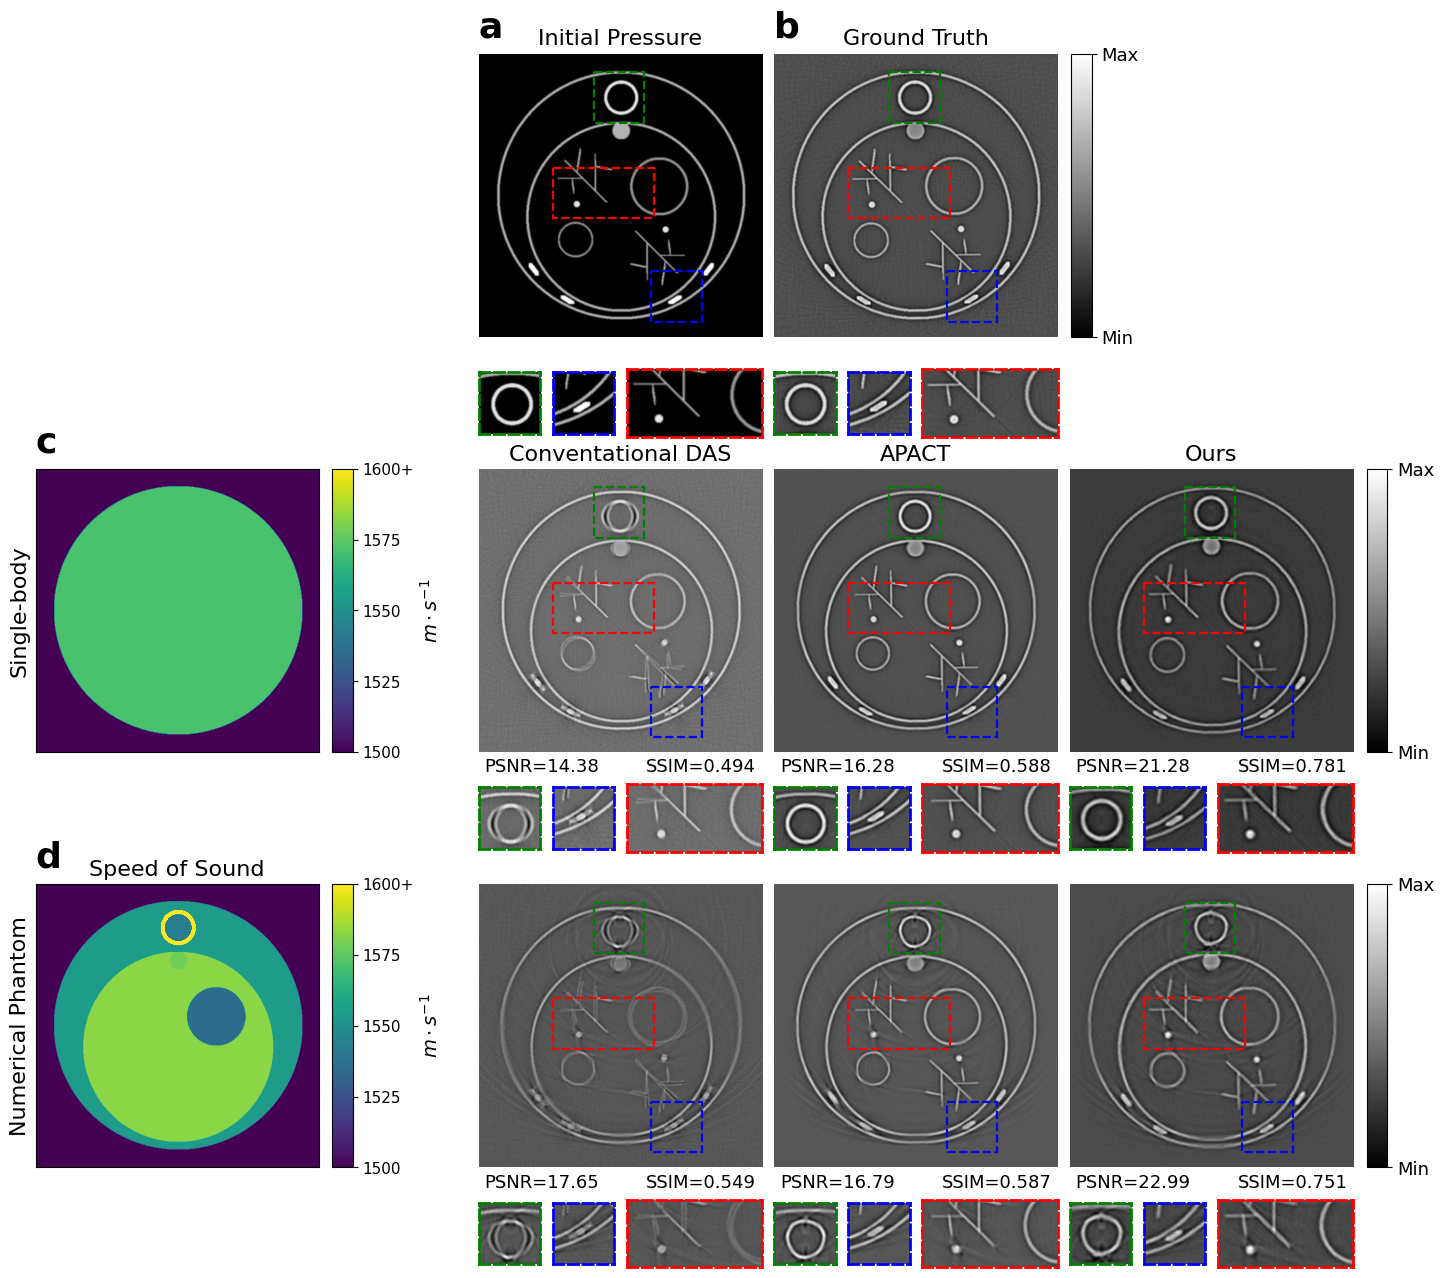

In [8]:
fig, main_ax = plt.subplots(figsize=(17, 16))
gs = gridspec.GridSpec(15, 18)
norm_sos = Normalize(vmax=1600, vmin=1500)
norm_img = matplotlib.colors.Normalize(vmax=1, vmin=0)
patches = [(36, 227, 100, 100, 'green'), (430, 340, 100, 100,'blue'), (225, 146, 100, 200, 'red')]

ax = plt.subplot(gs[0:4,6:10])
plt.imshow(IP_img, cmap='gray', norm=norm_img)
plt.title('Initial Pressure', fontsize=16)
plt.title('a', loc='left', x=0.0, y=1.03, fontsize=26, fontweight='bold', color='black')
plt.axis('off')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[4:5,6+k:6+k+1+(k==2)])
        plt.imshow(IP_img[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
ax = plt.subplot(gs[0:4,10:14])
plt.imshow(gt, cmap='gray', norm=norm_img)
plt.title('Ground Truth', fontsize=16)
plt.title('b', loc='left', x=0.0, y=1.03, fontsize=26, fontweight='bold', color='black')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.set_ticks([0, 1])
cb.set_ticklabels(['Min', 'Max'], fontsize=13)
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[4:5,10+k:10+k+1+(k==2)])
        plt.imshow(gt[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
ax = plt.subplot(gs[10:14,0:4])
plt.imshow(SoS, norm=norm_sos)
plt.ylabel('Numerical Phantom', fontsize=16)
plt.title('Speed of Sound', fontsize=16)
plt.title('d', loc='left', x=0.0, y=1.03, fontsize=26, fontweight='bold', color='black')
plt.xticks([])
plt.yticks([])
cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.set_yticks([1500, 1525, 1550, 1575, 1600])
cb.ax.set_yticklabels(['1500', '1525', '1550', '1575', '1600+'], fontsize=11)
cb.set_label('$m \cdot s^{-1}$', fontsize=14)

ax = plt.subplot(gs[5:9,0:4])
plt.imshow(SoS_sb, norm=norm_sos)
plt.ylabel('Single-body', fontsize=16)
plt.title('c', loc='left', x=0.0, y=1.03, fontsize=26, fontweight='bold', color='black')
plt.xticks([])
plt.yticks([])
cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.set_yticks([1500, 1525, 1550, 1575, 1600])
cb.ax.set_yticklabels(['1500', '1525', '1550', '1575', '1600+'], fontsize=11)
cb.set_label('$m \cdot s^{-1}$', fontsize=14)


ax = plt.subplot(gs[10:14,6:10])
plt.imshow(rec_das, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_das, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_das, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.axis('off')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[14:15,6+k:6+k+1+(k==2)])
        plt.imshow(rec_das[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
ax = plt.subplot(gs[5:9,6:10])
plt.imshow(rec_das_sb, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_das_sb, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_das_sb, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.title('Conventational DAS', fontsize=16)
plt.axis('off')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[9:10,6+k:6+k+1+(k==2)])
        plt.imshow(rec_das_sb[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
            
ax = plt.subplot(gs[10:14,10:14])
plt.imshow(rec_apact, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_apact, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_apact, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.axis('off')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[14:15,10+k:10+k+1+(k==2)])
        plt.imshow(rec_apact[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
ax = plt.subplot(gs[5:9,10:14])
plt.imshow(rec_apact_sb, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_apact_sb, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_apact_sb, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.title('APACT', fontsize=16)
plt.axis('off')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[9:10,10+k:10+k+1+(k==2)])
        plt.imshow(rec_apact_sb[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
            
ax = plt.subplot(gs[10:14,14:18])
plt.imshow(rec_wiener, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_wiener, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_wiener, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.set_ticks([0, 1])
cb.set_ticklabels(['Min', 'Max'], fontsize=13)
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[14:15,14+k:14+k+1+(k==2)])
        plt.imshow(rec_wiener[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')
            
ax = plt.subplot(gs[5:9,14:18])
plt.imshow(rec_wiener_sb, cmap='gray', norm=norm_img)
plt.title('PSNR={:.2f}'.format(psnr(gt, rec_wiener_sb, data_range=1)), loc='left', x=0.02, y=-0.1, fontsize=13, color='black')
plt.title('SSIM={:.3f}'.format(ssim(gt, rec_wiener_sb, data_range=1)), loc='right', x=0.98, y=-0.1, fontsize=13, color='black')
plt.title('Ours', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.set_ticks([0, 1])
cb.set_ticklabels(['Min', 'Max'], fontsize=13)
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[9:10,14+k:14+k+1+(k==2)])
        plt.imshow(rec_wiener_sb[x:x+h, y:y+w], cmap='gray', norm=norm_img)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

# Horizontal lines
# main_ax.set_zorder(10)
# main_ax.set_ylim(0, 10)
# main_ax.set_xlim(0, 10)
# main_ax.hlines([0.954, 2.984, 4.33, 6.354], 3.75, 9.61, colors='yellow', linestyles='--', linewidth=1.5)
# main_ax.hlines([7.69], 3.75, 7.37, colors='yellow', linestyles='--', linewidth=1.5)
# main_ax.hlines([9.726], 3.75, 5.6, colors='yellow', linestyles='--', linewidth=1.5)
# main_ax.hlines([9.726], 6.0, 7.37, colors='yellow', linestyles='--', linewidth=1.5)
main_ax.axis('off')

plt.savefig('figure_simulation.png', bbox_inches='tight', dpi=256)